# eQQMIX : Entangled Quantum QMIX Algorithm -- eQVDN

Multi-agent learning by deriving $Q_{tot}$ from GHZ-entangled agent PQCs and joint measurements.

Inspired by the tutorial: https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning#3_deep_q-learning_with_pqc_q-function_approximators

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eqmarl import *
import pennylane as qml
import numpy as np
import functools as ft
import collections as cl
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import gymnasium as gym
from pathlib import Path
from PIL import Image

2023-12-21 16:05:54.794026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
class Rescaling(keras.layers.Layer):
    """Learnable rescaling from range [-1, 1] to range [0, 1]."""
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)),
            dtype='float32',
            trainable=True,
            name='obs-weights',
            )
        
    def call(self, inputs):
        # inputs = tf.math.abs(inputs)
        # inputs = tf.cast(inputs, dtype='float32')
        return tf.math.multiply(
            (1+inputs)/2., # Rescale from [-1, 1] to range [0, 1].
            tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0),
            )

In [5]:
def generate_model_Qlearning(n_wires, n_layers, observables, is_target):
    
    circuit = AgentCircuit(
        wires=n_wires,
        n_layers=n_layers,
        observables=observables,
    )
    qlayer = circuit.get_keras_layer(name='ReUploadingPQC')
    
    model = keras.Sequential([
            keras.Input(shape=(n_wires,), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            qlayer,
            # keras.layers.Lambda(lambda x: tf.math.abs(x)), # Convert complex to float via abs.
            keras.layers.Activation('tanh'), # Ensure outputs of PQC are in range [-1, 1].
            keras.Sequential([Rescaling(len(observables))], name=is_target*'Target'+'Q-values'),
        ],
        )
    return model
    

In [6]:
# env = gym.make('CartPole-v1')
n_actions = 2 # because `env.action_space.n == 2`
n_wires = 4 # because `env.observation_space.shape == (4,)`
# input_shape = (4,) # Shape of model input, which should match the observation vector shape `env.observation_space.shape == (4,)`

n_layers = 5 # Number of PQC layers.

observables = np.array([
    qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
    qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
    ])
# observables = lambda wires: [
#     qml.PauliZ(wires=0) @ qml.PauliZ(wires=1), # Z0 Z1 (action 0 -- "left")
#     qml.PauliZ(wires=2) @ qml.PauliZ(wires=3), # Z2 Z3 (action 1 -- "right")
#     ]

circuit = AgentCircuit(
    wires=n_wires,
    n_layers=n_layers,
    observables=observables,
)

# print(qml.draw(qnode, wire_order=list(range(n_wires)))())

In [7]:
model = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=False,
    )

model_target = generate_model_Qlearning(
    n_wires=n_wires,
    n_layers=n_layers,
    observables=observables,
    is_target=True,
    )
model_target.set_weights(model.get_weights())

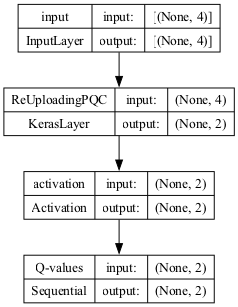

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

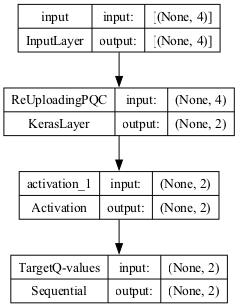

In [9]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ReUploadingPQC (KerasLayer  (None, 2)                 92        
 )                                                               
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
 Q-values (Sequential)       (None, 2)                 2         
                                                                 
Total params: 94 (376.00 Byte)
Trainable params: 94 (376.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
### Visualize the circuit.
weight_shapes = circuit.weight_shapes
weights = {
    k: np.random.uniform(low=0., high=np.pi, size=s)
    for k, s in weight_shapes.items()
}
# shape_var, shape_enc = circuit.shape
# weights_var = np.random.uniform(low=0., high=np.pi, size=shape_var)
# weights_enc = np.random.uniform(low=0., high=np.pi, size=shape_enc)
print(qml.draw(circuit, wire_order=circuit.wires)(**weights))

0: ─╭VariationalEncodingPQC─┤ ╭<Z@Z>
1: ─├VariationalEncodingPQC─┤ ╰<Z@Z>
2: ─├VariationalEncodingPQC─┤ ╭<Z@Z>
3: ─╰VariationalEncodingPQC─┤ ╰<Z@Z>


In [12]:
def interact_env(state, model, epsilon, n_actions, env):
    # state_shape = state.shape
    # state = np.asarray(state).reshape((1, *state_shape)) # Reshape to (1, features) so that batch_size=1.
    # state = tf.convert_to_tensor([state]) # Reshape to (1, features) so that batch_size=1.
    state = np.asarray(state).reshape((1, 4)) # Reshape to (1, features) so that batch_size=1.
    
    # Select action.
    coin = np.random.random()
    if coin > epsilon: # Epsilon-greedy
        q_vals = model([state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else: # Random action.
        action = np.random.choice(n_actions)
    
    next_state, reward, done, _, _ = env.step(action)
    next_state = np.asarray(next_state).reshape(state.shape)
    
    return dict(
        state=state,
        action=action,
        reward=reward,
        next_state=next_state,
        done=done,
    )

In [16]:
### Q-learning update function.

def Q_learning_update(states, actions, rewards, next_states, done, model, model_target, gamma, n_actions, optimizer_w_tups):
    
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    rewards = tf.convert_to_tensor(rewards)
    next_states = tf.convert_to_tensor(next_states)
    done = tf.convert_to_tensor(done)
    
    # Compute target Q-values and masks on sampled actions.
    future_rewards = model_target([next_states])
    target_q_values = rewards + (gamma * tf.reduce_max(future_rewards, axis=1) * (1. - done))
    
    masks = tf.one_hot(actions, n_actions)
    
    # Train the model using target Q-values.
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        q_values = model([states])
        print(f"{q_values=}")
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        loss = tf.keras.losses.Huber()(target_q_values, q_values_masked)
        
    # Backprop.
    grads = tape.gradient(loss, model.trainable_variables)
    for optimizer, w in optimizer_w_tups:
        optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

In [14]:
gamma = 0.99
n_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = cl.deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
steps_per_update = 10 # Train the model every x steps
steps_per_target_update = 30 # Update the target model every x steps

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

optimizer_w_tups = zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out])

In [17]:
### Main training loop

env = gym.make('CartPole-v1')

episode_reward_history = []
step_count = 0
for episode in range(n_episodes):
    episode_reward = 0
    state, _ = env.reset()
    
    while True:
        # Interact with environment.
        interaction = interact_env(state, model, epsilon, n_actions, env)
        
        # Preserve interaction in the replay memory.
        replay_memory.append(interaction)
        
        state = interaction['next_state']
        episode_reward += interaction['reward']
        step_count += 1
        
        if step_count % steps_per_update == 0:
            training_batch = np.random.choice(replay_memory, size=batch_size) # Randomly select interactions from replay memory and train on them.
            
            Q_learning_update(
                states=np.asarray([x['state'] for x in training_batch]).squeeze(),
                actions=np.asarray([x['action'] for x in training_batch]).squeeze(),
                rewards=np.asarray([x['reward'] for x in training_batch], dtype=np.float32).squeeze(),
                next_states=np.asarray([x['next_state'] for x in training_batch]).squeeze(),
                done=np.asarray([x['done'] for x in training_batch], dtype=np.float32).squeeze(),
                model=model,
                model_target=model_target,
                gamma=gamma,
                n_actions=n_actions,
                optimizer_w_tups=optimizer_w_tups,
            )
        
        if step_count % steps_per_target_update == 0:
            model_target.set_weights(model.get_weights())
        
        if interaction['done']:
            break
        
        # Decay epsilon.
        epsilon = max(epsilon * decay_epsilon, epsilon_min)
        episode_reward_history.append(episode_reward)
        
        if (episode+1) % 10 == 0:
            avg_rewards = np.mean(episode_reward_history[-10:])
            print("Episode {}/{}, average last 10 rewards {}".format(episode+1, n_episodes, avg_rewards))
            if avg_rewards >= 500.0:
                break

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.45243058, 0.47343975],
       [0.59274143, 0.4187792 ],
       [0.46274206, 0.50573695],
       [0.57404655, 0.40949935],
       [0.58871144, 0.327564  ],
       [0.5689731 , 0.44402298],
       [0.5998297 , 0.37654495],
       [0.4925599 , 0.390594  ],
       [0.58871144, 0.327564  ],
       [0.58871144, 0.327564  ],
       [0.46150568, 0.5070336 ],
       [0.46150568, 0.5070336 ],
       [0.5998297 , 0.37654495],
       [0.59274143, 0.4187792 ],
       [0.45271853, 0.4720967 ],
       [0.45464098, 0.46489215]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5443314 , 0.4330917 ],
       [0.68796945, 0.4177779 ],
       [0.5654103 , 0.41859978],
       [0.6627848 , 0.41404364],
       [0.6627848 , 0.41404364],
       [0.68016076, 0.39234936],
       [0.688049  , 0.36664972],
       [0.54178464, 0.4465127 ],
       [0.6627848 , 0.41404364],
       [0.54178464, 0.4465127 ],
       [0.6500364 , 0.3619932 ],
       [0.5080478 , 0.5635613 ],
       [0.51167583, 0.5583782 ],
       [0.5103268 , 0.5598219 ],
       [0.49607575, 0.53502023],
       [0.51167583, 0.5583782 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.68016076, 0.39234936],
       [0.62874717, 0.37477988],
       [0.6016119 , 0.46481675],
       [0.5680093 , 0.41129625],
       [0.6398312 , 0.48577014],
       [0.5680093 , 0.41129625],
       [0.5103268 , 0.5598219 ],
       [0.5269165 , 0.5311989 ],
       [0.688049  , 0.36664972],
       [0.54178464, 0.4465127 ],
       [0.62893707, 0.48752064],
       [0.6016119 , 0.46481675],
       [0.5030279 , 0.5151529 ],
       [0.6398312 , 0.48577014],
       [0.52556133, 0.5322919 ],
       [0.50534976, 0.5069794 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5030279 , 0.5151529 ],
       [0.5996005 , 0.4895961 ],
       [0.62874717, 0.37477988],
       [0.5080478 , 0.5635613 ],
       [0.5103268 , 0.5598219 ],
       [0.51167583, 0.5583782 ],
       [0.50054026, 0.52419823],
       [0.50117874, 0.5208486 ],
       [0.5024716 , 0.5073722 ],
       [0.6500364 , 0.3619932 ],
       [0.5643174 , 0.41257295],
       [0.5285761 , 0.54196787],
       [0.51167583, 0.5583782 ],
       [0.68016076, 0.39234936],
       [0.6627848 , 0.41404364],
       [0.5269165 , 0.5311989 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5680093 , 0.41129625],
       [0.6398312 , 0.48577014],
       [0.65072984, 0.36210987],
       [0.52556133, 0.5322919 ],
       [0.5050573 , 0.47786406],
       [0.59201974, 0.37695745],
       [0.6257572 , 0.37224132],
       [0.62909883, 0.30671224],
       [0.50616693, 0.55902857],
       [0.5443314 , 0.4330917 ],
       [0.5285761 , 0.54196787],
       [0.688049  , 0.36664972],
       [0.51167583, 0.5583782 ],
       [0.67685986, 0.43240094],
       [0.6500364 , 0.3619932 ],
       [0.5786578 , 0.50287235]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5103268 , 0.5598219 ],
       [0.59201974, 0.37695745],
       [0.50615   , 0.56070274],
       [0.5064444 , 0.5675577 ],
       [0.6041345 , 0.4977147 ],
       [0.50615   , 0.56070274],
       [0.688049  , 0.36664972],
       [0.4868018 , 0.544851  ],
       [0.4868018 , 0.544851  ],
       [0.5016255 , 0.5119683 ],
       [0.5030279 , 0.5151529 ],
       [0.67685986, 0.43240094],
       [0.5588382 , 0.4754428 ],
       [0.5064153 , 0.5028999 ],
       [0.6627848 , 0.41404364],
       [0.5008608 , 0.52272904]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.68016076, 0.39234936],
       [0.62893707, 0.48752064],
       [0.5436806 , 0.43491197],
       [0.57280314, 0.39423323],
       [0.6398312 , 0.48577014],
       [0.50036013, 0.52123517],
       [0.5033375 , 0.50187504],
       [0.48055515, 0.5401245 ],
       [0.65072984, 0.36210987],
       [0.5050573 , 0.47786406],
       [0.65072984, 0.36210987],
       [0.5623833 , 0.41685817],
       [0.50054437, 0.44675797],
       [0.57280314, 0.39423323],
       [0.49603945, 0.5603615 ],
       [0.47346058, 0.5343392 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.49915954, 0.5502746 ],
       [0.5680093 , 0.41129625],
       [0.5623833 , 0.41685817],
       [0.479177  , 0.4766275 ],
       [0.5064444 , 0.5675577 ],
       [0.50324374, 0.45256692],
       [0.68016076, 0.39234936],
       [0.496943  , 0.53711516],
       [0.5064153 , 0.5028999 ],
       [0.6257572 , 0.37224132],
       [0.50101614, 0.48727113],
       [0.5020524 , 0.5092001 ],
       [0.496943  , 0.53711516],
       [0.5064444 , 0.5675577 ],
       [0.47346058, 0.5343392 ],
       [0.53839153, 0.49495667]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5484237 , 0.4224446 ],
       [0.5654103 , 0.41859978],
       [0.5269165 , 0.5311989 ],
       [0.4860382 , 0.54915947],
       [0.6078388 , 0.49698234],
       [0.5534585 , 0.4109046 ],
       [0.47859365, 0.54891133],
       [0.62909883, 0.30671224],
       [0.47859365, 0.54891133],
       [0.5510085 , 0.41662744],
       [0.4868018 , 0.544851  ],
       [0.55935174, 0.40299824],
       [0.5443314 , 0.4330917 ],
       [0.49061823, 0.45987716],
       [0.49607575, 0.53502023],
       [0.52556133, 0.5322919 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5024716 , 0.5073722 ],
       [0.62874717, 0.37477988],
       [0.47068268, 0.45908552],
       [0.68796945, 0.4177779 ],
       [0.68573   , 0.3665999 ],
       [0.46733773, 0.44073886],
       [0.54581535, 0.4281912 ],
       [0.50612736, 0.55866253],
       [0.5103268 , 0.5598219 ],
       [0.5016695 , 0.49542084],
       [0.5588382 , 0.4754428 ],
       [0.54581535, 0.4281912 ],
       [0.50117874, 0.5208486 ],
       [0.49915954, 0.5502746 ],
       [0.5981566 , 0.45196694],
       [0.5623833 , 0.41685817]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5016695 , 0.49542084],
       [0.5050573 , 0.47786406],
       [0.5017918 , 0.52010185],
       [0.51167583, 0.5583782 ],
       [0.5269165 , 0.5311989 ],
       [0.5643174 , 0.41257295],
       [0.63199615, 0.36654815],
       [0.48717678, 0.56963557],
       [0.4624139 , 0.47613886],
       [0.56069076, 0.47351566],
       [0.4454077 , 0.5277732 ],
       [0.5555853 , 0.40558115],
       [0.47346058, 0.5343392 ],
       [0.50036013, 0.52123517],
       [0.42010662, 0.515266  ],
       [0.50036013, 0.52123517]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50439554, 0.46022615],
       [0.50378543, 0.546928  ],
       [0.5668844 , 0.47538677],
       [0.49821854, 0.56061417],
       [0.5527352 , 0.41449845],
       [0.48744604, 0.45506233],
       [0.5527352 , 0.41449845],
       [0.5588382 , 0.4754428 ],
       [0.5225243 , 0.5452841 ],
       [0.40777084, 0.51436967],
       [0.5643174 , 0.41257295],
       [0.62909883, 0.30671224],
       [0.5030279 , 0.5151529 ],
       [0.57503146, 0.49659815],
       [0.48717678, 0.56963557],
       [0.49821854, 0.56061417]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50363094, 0.48482096],
       [0.49603945, 0.5603615 ],
       [0.54178464, 0.4465127 ],
       [0.54178464, 0.4465127 ],
       [0.6552311 , 0.45978007],
       [0.5495992 , 0.42406398],
       [0.5680093 , 0.41129625],
       [0.57095224, 0.40258586],
       [0.6799453 , 0.37027812],
       [0.50324374, 0.45256692],
       [0.50337076, 0.497873  ],
       [0.5024716 , 0.5073722 ],
       [0.6552311 , 0.45978007],
       [0.5555853 , 0.40558115],
       [0.492225  , 0.45088834],
       [0.6552311 , 0.45978007]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.57503146, 0.49659815],
       [0.5064444 , 0.5675577 ],
       [0.62893707, 0.48752064],
       [0.59201974, 0.37695745],
       [0.47346058, 0.5343392 ],
       [0.5032212 , 0.50059825],
       [0.46552375, 0.47593942],
       [0.54805696, 0.42846006],
       [0.6344217 , 0.45011172],
       [0.62893707, 0.48752064],
       [0.6627848 , 0.41404364],
       [0.47741982, 0.4521358 ],
       [0.52556133, 0.5322919 ],
       [0.5168755 , 0.5483089 ],
       [0.50378543, 0.546928  ],
       [0.5051088 , 0.46851096]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50054026, 0.52419823],
       [0.5269165 , 0.5311989 ],
       [0.48717678, 0.56963557],
       [0.47346058, 0.5343392 ],
       [0.62955856, 0.36972517],
       [0.65072984, 0.36210987],
       [0.4860382 , 0.54915947],
       [0.5588382 , 0.4754428 ],
       [0.6080112 , 0.47071105],
       [0.499772  , 0.47358564],
       [0.5611418 , 0.39751863],
       [0.5027685 , 0.5165614 ],
       [0.50324374, 0.45256692],
       [0.5051088 , 0.46851096],
       [0.50311124, 0.5058684 ],
       [0.5168755 , 0.5483089 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.40777084, 0.51436967],
       [0.5007993 , 0.51898146],
       [0.5701594 , 0.41099936],
       [0.56652325, 0.41806805],
       [0.59201974, 0.37695745],
       [0.688049  , 0.36664972],
       [0.46733773, 0.44073886],
       [0.60140973, 0.49749509],
       [0.50612736, 0.55866253],
       [0.50612736, 0.55866253],
       [0.50135654, 0.52355677],
       [0.5510085 , 0.41662744],
       [0.5168755 , 0.5483089 ],
       [0.54805696, 0.42846006],
       [0.496943  , 0.53711516],
       [0.6080112 , 0.47071105]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.479177  , 0.4766275 ],
       [0.47830716, 0.533525  ],
       [0.5080478 , 0.5635613 ],
       [0.47859365, 0.54891133],
       [0.49603945, 0.5603615 ],
       [0.47068268, 0.45908552],
       [0.54805696, 0.42846006],
       [0.6080112 , 0.47071105],
       [0.63199615, 0.36654815],
       [0.50628364, 0.4924217 ],
       [0.68573   , 0.3665999 ],
       [0.4725127 , 0.5457438 ],
       [0.50439554, 0.46022615],
       [0.57280314, 0.39423323],
       [0.643365  , 0.37192783],
       [0.6344217 , 0.45011172]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.56652325, 0.41806805],
       [0.550752  , 0.4189884 ],
       [0.6627848 , 0.41404364],
       [0.39371035, 0.5782808 ],
       [0.40777084, 0.51436967],
       [0.496943  , 0.53711516],
       [0.39371035, 0.5782808 ],
       [0.52556133, 0.5322919 ],
       [0.45512068, 0.52583796],
       [0.62955856, 0.36972517],
       [0.57095224, 0.40258586],
       [0.50324374, 0.45256692],
       [0.4971923 , 0.5713461 ],
       [0.62893707, 0.48752064],
       [0.5555853 , 0.40558115],
       [0.48026782, 0.5537781 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5080478 , 0.5635613 ],
       [0.47668037, 0.55018896],
       [0.50566626, 0.4999187 ],
       [0.5042201 , 0.50871706],
       [0.5016695 , 0.49542084],
       [0.49467638, 0.5375792 ],
       [0.48744604, 0.45506233],
       [0.67685986, 0.43240094],
       [0.48026782, 0.5537781 ],
       [0.5560915 , 0.40385294],
       [0.62909883, 0.30671224],
       [0.4959339 , 0.5313216 ],
       [0.5484237 , 0.4224446 ],
       [0.5490274 , 0.41788548],
       [0.4860382 , 0.54915947],
       [0.4913137 , 0.5604995 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5019718 , 0.51495975],
       [0.4817707 , 0.44845802],
       [0.50693095, 0.44725105],
       [0.6500364 , 0.3619932 ],
       [0.6016119 , 0.46481675],
       [0.57503146, 0.49659815],
       [0.49615118, 0.5190379 ],
       [0.43300536, 0.5208329 ],
       [0.50054026, 0.52419823],
       [0.55935174, 0.40299824],
       [0.50117874, 0.5208486 ],
       [0.54860103, 0.44468614],
       [0.5981566 , 0.45196694],
       [0.49474588, 0.5312126 ],
       [0.55421054, 0.43599433],
       [0.41709876, 0.49978572]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.4971923 , 0.5713461 ],
       [0.49603945, 0.5603615 ],
       [0.5008608 , 0.52272904],
       [0.4454077 , 0.5277732 ],
       [0.5510085 , 0.41662744],
       [0.50054026, 0.52419823],
       [0.50616693, 0.55902857],
       [0.5017918 , 0.52010185],
       [0.47666734, 0.5573208 ],
       [0.5654103 , 0.41859978],
       [0.5510022 , 0.4386133 ],
       [0.6398312 , 0.48577014],
       [0.4970683 , 0.47560012],
       [0.50615   , 0.56070274],
       [0.46733773, 0.44073886],
       [0.4958154 , 0.5255242 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5080848 , 0.4593968 ],
       [0.5611418 , 0.39751863],
       [0.5027685 , 0.5165614 ],
       [0.6041345 , 0.4977147 ],
       [0.49230155, 0.57735616],
       [0.50135654, 0.52355677],
       [0.4868018 , 0.544851  ],
       [0.62909883, 0.30671224],
       [0.68796945, 0.4177779 ],
       [0.55694073, 0.42794132],
       [0.6552311 , 0.45978007],
       [0.42010662, 0.515266  ],
       [0.6080112 , 0.47071105],
       [0.4918649 , 0.5507384 ],
       [0.67685986, 0.43240094],
       [0.4780129 , 0.4535533 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50628364, 0.4924217 ],
       [0.49358603, 0.5416585 ],
       [0.4972489 , 0.44075823],
       [0.50616693, 0.55902857],
       [0.46552375, 0.47593942],
       [0.4868018 , 0.544851  ],
       [0.41709876, 0.49978572],
       [0.49468076, 0.5739067 ],
       [0.4624139 , 0.47613886],
       [0.50693095, 0.44725105],
       [0.50311124, 0.5058684 ],
       [0.5168755 , 0.5483089 ],
       [0.499772  , 0.47358564],
       [0.46991524, 0.4671599 ],
       [0.50324374, 0.45256692],
       [0.59201974, 0.37695745]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.54581535, 0.4281912 ],
       [0.6121386 , 0.4010332 ],
       [0.47068268, 0.45908552],
       [0.49528915, 0.5347445 ],
       [0.51167583, 0.5583782 ],
       [0.5064153 , 0.5028999 ],
       [0.4725127 , 0.5457438 ],
       [0.51167583, 0.5583782 ],
       [0.5786578 , 0.50287235],
       [0.50500125, 0.5139613 ],
       [0.42010662, 0.515266  ],
       [0.54178464, 0.4465127 ],
       [0.5034052 , 0.4940689 ],
       [0.4594678 , 0.49536613],
       [0.50303066, 0.5586542 ],
       [0.5027685 , 0.5165614 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.39371035, 0.5782808 ],
       [0.5443314 , 0.4330917 ],
       [0.54178464, 0.4465127 ],
       [0.5560915 , 0.40385294],
       [0.55694073, 0.42794132],
       [0.50776035, 0.45315188],
       [0.6041345 , 0.4977147 ],
       [0.5084718 , 0.50096697],
       [0.5715744 , 0.39768845],
       [0.5080848 , 0.4593968 ],
       [0.5007993 , 0.51898146],
       [0.4971923 , 0.5713461 ],
       [0.42185697, 0.5150223 ],
       [0.47346058, 0.5343392 ],
       [0.5578661 , 0.39843753],
       [0.65072984, 0.36210987]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.4958154 , 0.5255242 ],
       [0.49312547, 0.5429456 ],
       [0.50628364, 0.4924217 ],
       [0.50036013, 0.52123517],
       [0.54867405, 0.42654485],
       [0.6799453 , 0.37027812],
       [0.49474588, 0.5312126 ],
       [0.50615   , 0.56070274],
       [0.4725127 , 0.5457438 ],
       [0.48717678, 0.56963557],
       [0.5605576 , 0.42945555],
       [0.5633092 , 0.4111355 ],
       [0.5245572 , 0.4541441 ],
       [0.5103268 , 0.5598219 ],
       [0.4959339 , 0.5313216 ],
       [0.50222224, 0.56197196]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.55935174, 0.40299824],
       [0.50117874, 0.5208486 ],
       [0.46187508, 0.5336454 ],
       [0.54790837, 0.4467803 ],
       [0.640857  , 0.3714175 ],
       [0.4849567 , 0.44955787],
       [0.4624139 , 0.47613886],
       [0.550752  , 0.4189884 ],
       [0.50222224, 0.56197196],
       [0.56553864, 0.41646656],
       [0.49211255, 0.45725325],
       [0.45512068, 0.52583796],
       [0.50303066, 0.5586542 ],
       [0.51167583, 0.5583782 ],
       [0.50643396, 0.50677353],
       [0.494149  , 0.56249934]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5030279 , 0.5151529 ],
       [0.5103268 , 0.5598219 ],
       [0.5006106 , 0.560093  ],
       [0.5016695 , 0.49542084],
       [0.5063177 , 0.5078884 ],
       [0.49230155, 0.57735616],
       [0.68796945, 0.4177779 ],
       [0.43792486, 0.50698096],
       [0.5715744 , 0.39768845],
       [0.47012275, 0.5530787 ],
       [0.5657055 , 0.41259262],
       [0.5106024 , 0.5525028 ],
       [0.6546298 , 0.35835996],
       [0.5068903 , 0.5064863 ],
       [0.47666734, 0.5573208 ],
       [0.5269165 , 0.5311989 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50776035, 0.45315188],
       [0.5087981 , 0.49912962],
       [0.5027085 , 0.43942142],
       [0.50869375, 0.4997572 ],
       [0.42835775, 0.50999916],
       [0.5064794 , 0.50784314],
       [0.40777084, 0.51436967],
       [0.50324374, 0.45256692],
       [0.5087981 , 0.49912962],
       [0.45512068, 0.52583796],
       [0.6121386 , 0.4010332 ],
       [0.5055773 , 0.5101738 ],
       [0.4913137 , 0.5604995 ],
       [0.48246634, 0.5605294 ],
       [0.54867405, 0.42654485],
       [0.4972489 , 0.44075823]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.46762648, 0.5402742 ],
       [0.5024477 , 0.5610375 ],
       [0.4913137 , 0.5604995 ],
       [0.5029816 , 0.5449662 ],
       [0.50544715, 0.5132987 ],
       [0.50642836, 0.5066633 ],
       [0.4860382 , 0.54915947],
       [0.55474424, 0.4098333 ],
       [0.6080112 , 0.47071105],
       [0.44202778, 0.5146947 ],
       [0.5064794 , 0.50784314],
       [0.50723183, 0.50596505],
       [0.56613284, 0.41716236],
       [0.6041345 , 0.4977147 ],
       [0.50378543, 0.546928  ],
       [0.5080848 , 0.4593968 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.50537765, 0.5112081 ],
       [0.50869375, 0.4997572 ],
       [0.50660866, 0.5577352 ],
       [0.62955856, 0.36972517],
       [0.49665117, 0.51432157],
       [0.48717678, 0.56963557],
       [0.494149  , 0.56249934],
       [0.49603945, 0.5603615 ],
       [0.50701946, 0.5570601 ],
       [0.47346058, 0.5343392 ],
       [0.5003693 , 0.5608539 ],
       [0.50566626, 0.4999187 ],
       [0.6546298 , 0.35835996],
       [0.6552311 , 0.45978007],
       [0.6799453 , 0.37027812],
       [0.50934845, 0.4996677 ]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5032212 , 0.50059825],
       [0.5358627 , 0.4381553 ],
       [0.4972812 , 0.5668399 ],
       [0.5029816 , 0.5449662 ],
       [0.4882788 , 0.5580789 ],
       [0.50672066, 0.50710833],
       [0.5055773 , 0.5101738 ],
       [0.5063177 , 0.5078884 ],
       [0.5666411 , 0.41616806],
       [0.50723183, 0.50596505],
       [0.48910365, 0.45184147],
       [0.5103268 , 0.5598219 ],
       [0.62874717, 0.37477988],
       [0.49585545, 0.47230828],
       [0.6257572 , 0.37224132],
       [0.48910365, 0.45184147]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.56613284, 0.41716236],
       [0.5285761 , 0.54196787],
       [0.49585545, 0.47230828],
       [0.5020524 , 0.5092001 ],
       [0.5074871 , 0.4778109 ],
       [0.47668037, 0.55018896],
       [0.40968037, 0.51083666],
       [0.50643396, 0.50677353],
       [0.4624139 , 0.47613886],
       [0.6016119 , 0.46481675],
       [0.5089054 , 0.50060797],
       [0.5077473 , 0.5147032 ],
       [0.5055617 , 0.50987405],
       [0.50660866, 0.5577352 ],
       [0.53008056, 0.44502014],
       [0.6552311 , 0.45978007]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.5030279 , 0.5151529 ],
       [0.56069076, 0.47351566],
       [0.55561274, 0.43140703],
       [0.51172227, 0.5517242 ],
       [0.46552375, 0.47593942],
       [0.4725127 , 0.5457438 ],
       [0.40777084, 0.51436967],
       [0.50178295, 0.55874467],
       [0.50117874, 0.5208486 ],
       [0.46735102, 0.5278003 ],
       [0.50806934, 0.46564662],
       [0.50806934, 0.46564662],
       [0.5077407 , 0.50532824],
       [0.49061823, 0.45987716],
       [0.49230155, 0.57735616],
       [0.5087981 , 0.49912962]], dtype=float32)>


q_values=<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0.643365  , 0.37192783],
       [0.48758444, 0.44743994],
       [0.5055773 , 0.5101738 ],
       [0.49585545, 0.47230828],
       [0.4780129 , 0.4535533 ],
       [0.49061823, 0.45987716],
       [0.50616693, 0.55902857],
       [0.5484237 , 0.4224446 ],
       [0.41709876, 0.49978572],
       [0.6016119 , 0.46481675],
       [0.5006106 , 0.560093  ],
       [0.50701946, 0.5570601 ],
       [0.5032212 , 0.50059825],
       [0.50691295, 0.48508537],
       [0.48717678, 0.56963557],
       [0.56234425, 0.42094722]], dtype=float32)>


KeyboardInterrupt: 

In [40]:
env = gym.make('CartPole-v1')
epsilon = 0

state, _ = env.reset()
trajectory = []
for t in range(100):
    traj = interact_env(state, model, epsilon, n_actions, env)
    trajectory.append(traj)
    if traj['done']:
        break

trajectory

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


[{'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00623899, -0.18428296,  0.00549074,  0.29789397]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[ 0.00255333, -0.37948275,  0.01144862,  0.5923035 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.00503632, -0.57476306,  0.02329469,  0.8885706 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.00542063, 0.0035057 ]], dtype=float32),
  'action': 0,
  'reward': 1.0,
  'next_state': array([[-0.01653158, -0.7701933 ,  0.0410661 ,  1.1884844 ]],
        dtype=float32),
  'done': False},
 {'state': array([[0.00602067, 0.01091631, 0.0054206

In [44]:
def render_episode_as_gif_frames(env_name, actor, max_steps):
    env = gym.make(env_name, render_mode='rgb_array')
    
    state, _ = env.reset()
    
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images = [Image.fromarray(screen)]
    
    for i in range(1, max_steps+1):
        state = tf.expand_dims(state, 0)
        action_probs = actor(state)
        action = np.argmax(np.squeeze(action_probs))
        
        state, reward, done, _, _ = env.step(action)
        state = tf.constant(state, dtype=tf.float32)
        
        screen = env.render()
        images.append(Image.fromarray(screen))
        
        if done:
            break

    return images

def save_frames_as_gif(frames: list[Image.Image], path: Path, **kwargs):
    frames[1].save(
        path,
        save_all=True,
        append_images=frames[2:],
        optimize=False,
        duration=40,
        loop=0,
        **kwargs,
    )
    
import IPython.display
def display_gif(path: Path) -> IPython.display.DisplayHandle:
    return display(
        IPython.display.Image(
            data=open(path,'rb').read(), format='png'),
        )

/usr/local/Caskroom/miniforge/base/envs/qml/lib/python3.11/site-packages/pennylane/math/utils.py:227: UserWarning: Contains tensors of types {'autograd', 'tensorflow'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


rendering 10 frames to GIF ./images/gym_CartPole.gif


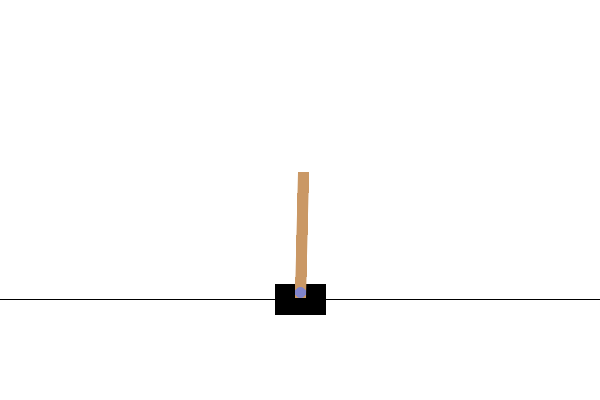

In [45]:
gif_path = './images/gym_CartPole.gif'
frames = render_episode_as_gif_frames('CartPole-v1', model, 100)
print(f"rendering {len(frames)} frames to GIF {gif_path}")
save_frames_as_gif(frames, gif_path)
display_gif(gif_path)